In [1]:
import os
import torch
import torch.nn as nn

os.environ["TORCH"] = torch.__version__
from torch_geometric.datasets import TUDataset

In [2]:
dataset = TUDataset(root="./data/TUDataset", name="MUTAG")
print(dataset)
print("n of classes:", dataset.num_classes)
print("n of graphs", len(dataset))
print("n of feature", dataset.num_features)

MUTAG(188)
n of classes: 2
n of graphs 188
n of feature 7


In [3]:
data = dataset[0]
print(data.keys())
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

['x', 'y', 'edge_index', 'edge_attr']
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

num_train = int(len(dataset) * 0.8)
train_dataset = dataset[:num_train]
test_dataset = dataset[num_train:]

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")

Number of training graphs: 150
Number of test graphs: 38


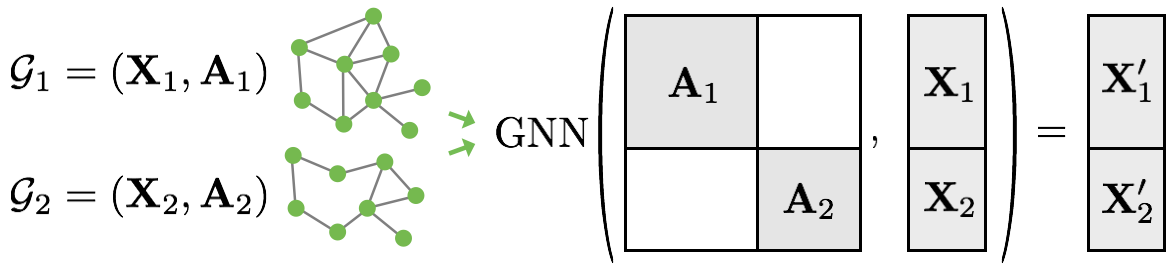

In [5]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

for step, data in enumerate(train_loader):
    print(f"Step {step + 1}:")
    print("=======")
    print(f"Number of graphs in the current batch: {data.num_graphs}")
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



Here, we opt for a `batch_size` of 64, leading to 3 (randomly shuffled) mini-batches, containing all $2 \cdot 64+22 = 150$ graphs.

Furthermore, each `Batch` object is equipped with a **`batch` vector**, which maps each node to its respective graph in the batch:

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ]
$$

In [73]:
print(data.batch)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 11, 

## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:
<br>


```python
global_mean_pool(
    x: torch.Tensor,
    batch: Union[torch.Tensor, NoneType],
    size: Union[int, NoneType] = None,
) -> torch.Tensor
```

Args:
    x (torch.Tensor): Node feature matrix
        $$\mathbf{X} \in \mathbb{R}^{(N_1 + \ldots + N_B) \times F}$$.
    batch (torch.Tensor, optional): The batch vector
        $$\mathbf{b} \in {\{ 0, \ldots, B-1\}}^N$$, which assigns
        each node to a specific example.
    size (int, optional): The number of examples $B$.
        Automatically calculated if not given. (default: :obj:`None`)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool


class GCN(nn.Module):
    def __init__(self, hidden_feats):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, hidden_feats)
        self.conv3 = GCNConv(hidden_feats, hidden_feats)
        self.linear = nn.Linear(hidden_feats, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = x.relu()
        x = self.conv3(x, edge_index)

        # Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = F.dropout(x, 0.5, training=self.training)
        x = self.linear(x)
        return x

In [65]:
model = GCN(hidden_feats=64)
model

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)

In [101]:
model = GCN(64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()


def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

In [102]:
train_accs = []
test_accs = []
for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}"
        )

Epoch: 010, Train Acc: 0.7333, Test Acc: 0.7105
Epoch: 020, Train Acc: 0.7467, Test Acc: 0.7632
Epoch: 030, Train Acc: 0.7667, Test Acc: 0.6842
Epoch: 040, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 050, Train Acc: 0.7533, Test Acc: 0.7105
Epoch: 060, Train Acc: 0.7667, Test Acc: 0.7368
Epoch: 070, Train Acc: 0.7867, Test Acc: 0.7895
Epoch: 080, Train Acc: 0.7667, Test Acc: 0.7632
Epoch: 090, Train Acc: 0.7800, Test Acc: 0.7632
Epoch: 100, Train Acc: 0.7867, Test Acc: 0.7632
Epoch: 110, Train Acc: 0.7800, Test Acc: 0.7632
Epoch: 120, Train Acc: 0.7800, Test Acc: 0.8158
Epoch: 130, Train Acc: 0.7867, Test Acc: 0.8421
Epoch: 140, Train Acc: 0.7800, Test Acc: 0.8421
Epoch: 150, Train Acc: 0.7867, Test Acc: 0.8158
Epoch: 160, Train Acc: 0.7600, Test Acc: 0.8158
Epoch: 170, Train Acc: 0.8067, Test Acc: 0.8421


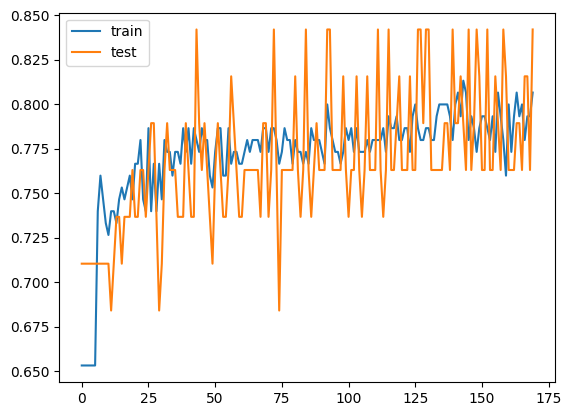

In [105]:
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

plt.plot(train_accs, label="train")
plt.plot(test_accs, label="test")
plt.legend()
plt.show()

As one can see, our model reaches around **80% test accuracy**.
Reasons for the fluctations in accuracy can be explained by the rather small dataset (only 38 test graphs), and usually disappear once one applies GNNs to larger datasets.

## (Optional) Exercise

Can we do better than this?
As multiple papers pointed out ([Xu et al. (2018)](https://arxiv.org/abs/1810.00826), [Morris et al. (2018)](https://arxiv.org/abs/1810.02244)), applying **neighborhood normalization decreases the expressivity of GNNs in distinguishing certain graph structures**.
An alternative formulation ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)) omits neighborhood normalization completely and adds a simple skip-connection to the GNN layer in order to preserve central node information:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

This layer is implemented under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) in PyTorch Geometric.

As an exercise, you are invited to complete the following code to the extent that it makes use of PyG's `GraphConv` rather than `GCNConv`.
This should bring you close to **82% test accuracy**.